# Test results on the classic and extended Wright-Fisher (WF) model

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from evo_models import WF, WF_bottleneck, WF_DFE
import pickle
import torch
import matplotlib 
from seaborn import histplot, kdeplot
import warnings
import torch

warnings.simplefilter('ignore', FutureWarning)
def change_font(fontsize):
    matplotlib.rcParams['xtick.labelsize'] = fontsize
    matplotlib.rcParams['ytick.labelsize'] = fontsize
    matplotlib.rcParams['font.size'] = fontsize


In [2]:
change_font(24)

def accuracy(samples, thetas, abc=False, non_sbi=False):
    if non_sbi:
        return samples - thetas
    accs = torch.empty(len(thetas),len(thetas[0]))
    for i in range(len(thetas)):
        samps = samples[:,i]
        if abc:
            samps = samples[i]
        accs[i] = samps.mean(0) - thetas[i]
    return accs

def plot_accuracy(ax, accs, color, label):
    for i in range(len(ax)):
        histplot(accs[:,i],ax=ax[i], stat='density', color=color, bins=10, label=label)
        # kdeplot(accs[:,i],ax=ax[i],fill=True, color=color, label=label)
    return


def coverage_old(samples, thetas, conf_levels=[0.1*i for i in range(1,10)] +[0.95]):
    covs = torch.empty(len(conf_levels), len(thetas), len(thetas[0]))
    for j in range(len(conf_levels)):
        conf_level = conf_levels[j]   
        taken_samples = samples[:int(conf_level*len(samples))+1]
        hdi = [torch.quantile(samples, (1-conf_level)/2, 0), torch.quantile(samples,(1+conf_level)/2, 0)]
        covs[j,:] = ((thetas > hdi[0])*(thetas < hdi[1]))
    return covs.mean(1)


        
def plot_results(model, architecture, color, fig, ax, cov_leg=False, abc=False, non_sbi=False):

    ax['A'].set_title('A',loc='left')
    ax['B'].set_title('B',loc='left')
    ax['C'].set_title('C',loc='left')

    ax['C'].plot(np.linspace(0,1,100),np.linspace(0,1,100), color='k', label='Ideal coverage' if cov_leg else '', ls='--')
    ax['C'].set_xlabel('Expected Coverage')
    ax['C'].set_ylabel('Observed Coverage')
    if cov_leg:
        ax['C'].legend()

    ax['A'].set_xlabel('$log_{10}[s^{est} / {s^{True}}]$')
    ax['B'].set_xlabel('$log_{10}[δ^{est} / {δ^{True}}]$')
    
    
    if cov_leg:
        ax['C'].legend()
    ax['B'].set_ylabel('')
    
    axx = [ax['A'], ax['B']]

    thetas = torch.load(f'test_sims/test_theta_{model}.pt')
    
    if non_sbi:
        samples = torch.load(f'test_sims/predictions_{model}_{architecture}.pt').cpu()
        accs = accuracy(samples, thetas, abc, non_sbi)
        plot_accuracy(axx, accs, color=color, label=f'{architecture.upper()} - {model.replace("_", " + ")}')
        ax['A'].legend(loc='upper left', fontsize=20)
        return
    
    else:
        samples = torch.load(f'test_sims/samples_{model}_{architecture}.pt')
        accs = accuracy(samples, thetas, abc, non_sbi)
        plot_accuracy(axx, accs, color=color, label=f'{architecture.upper()} - {model.replace("_", " + ")}')
        ax['A'].legend(loc='upper left', fontsize=20)
    
    conf_levels=[0.1*i for i in range(1,10)] +[0.95]
    covs = coverage_old(samples, thetas, conf_levels)
    params =  ['$s$', '$δ$']
    for i in range(len(params)):
        for j in range(len(covs)):
            ax['C'].text(conf_levels[j], covs[j,i], params[i], color=color)
    
    return

## Plot accuracy and uncertainty (coverage)

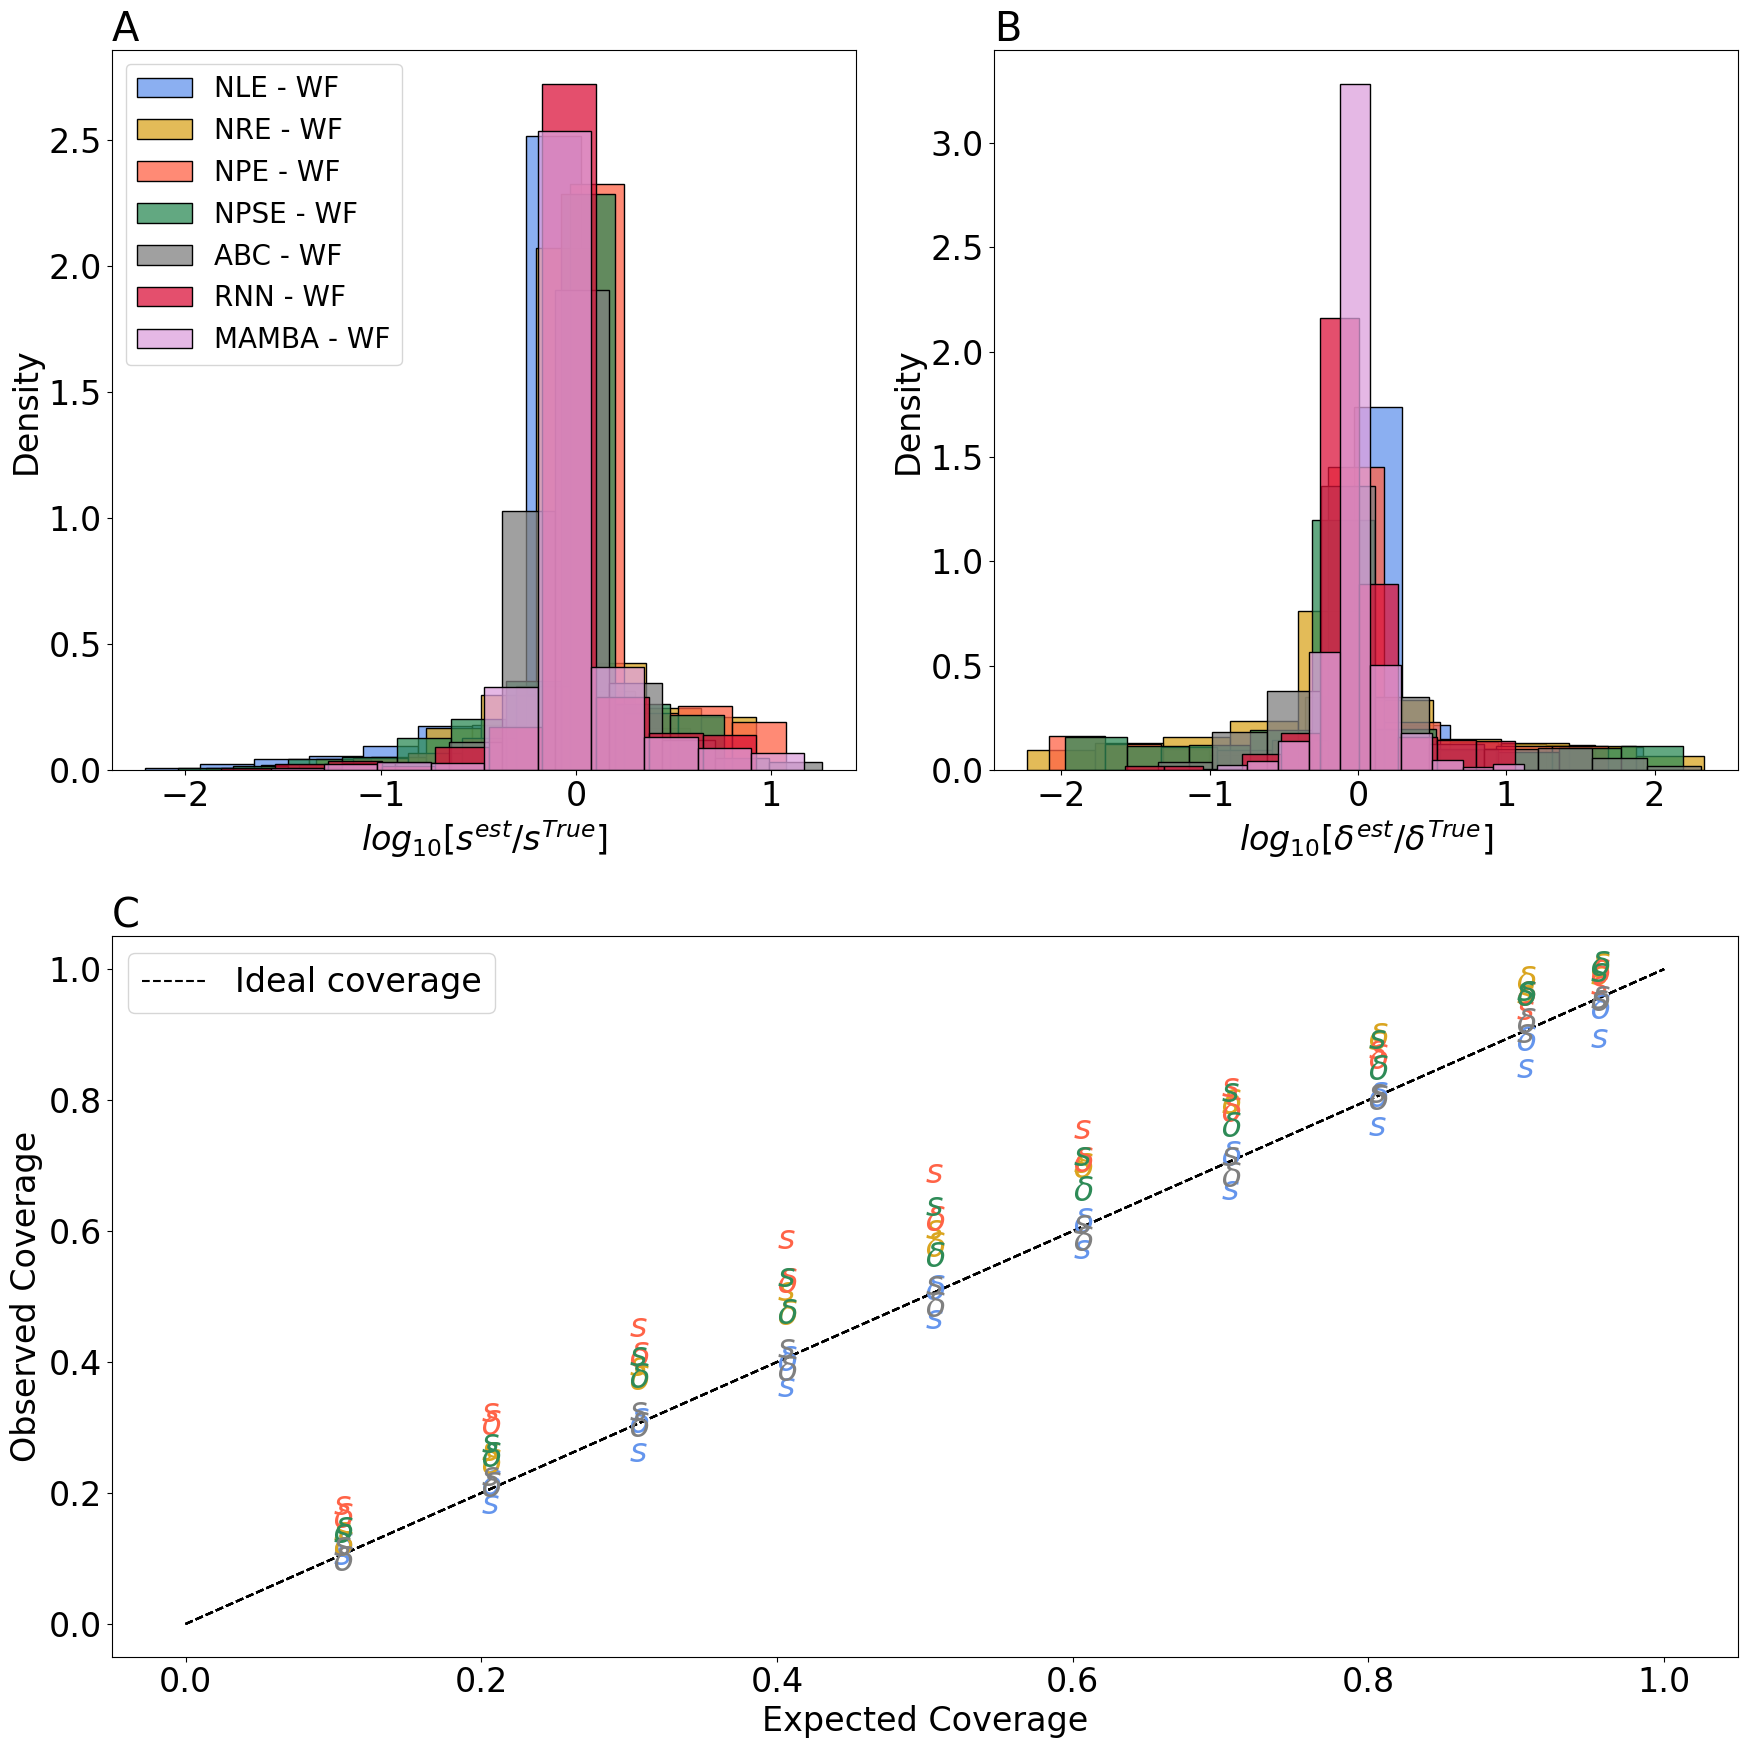

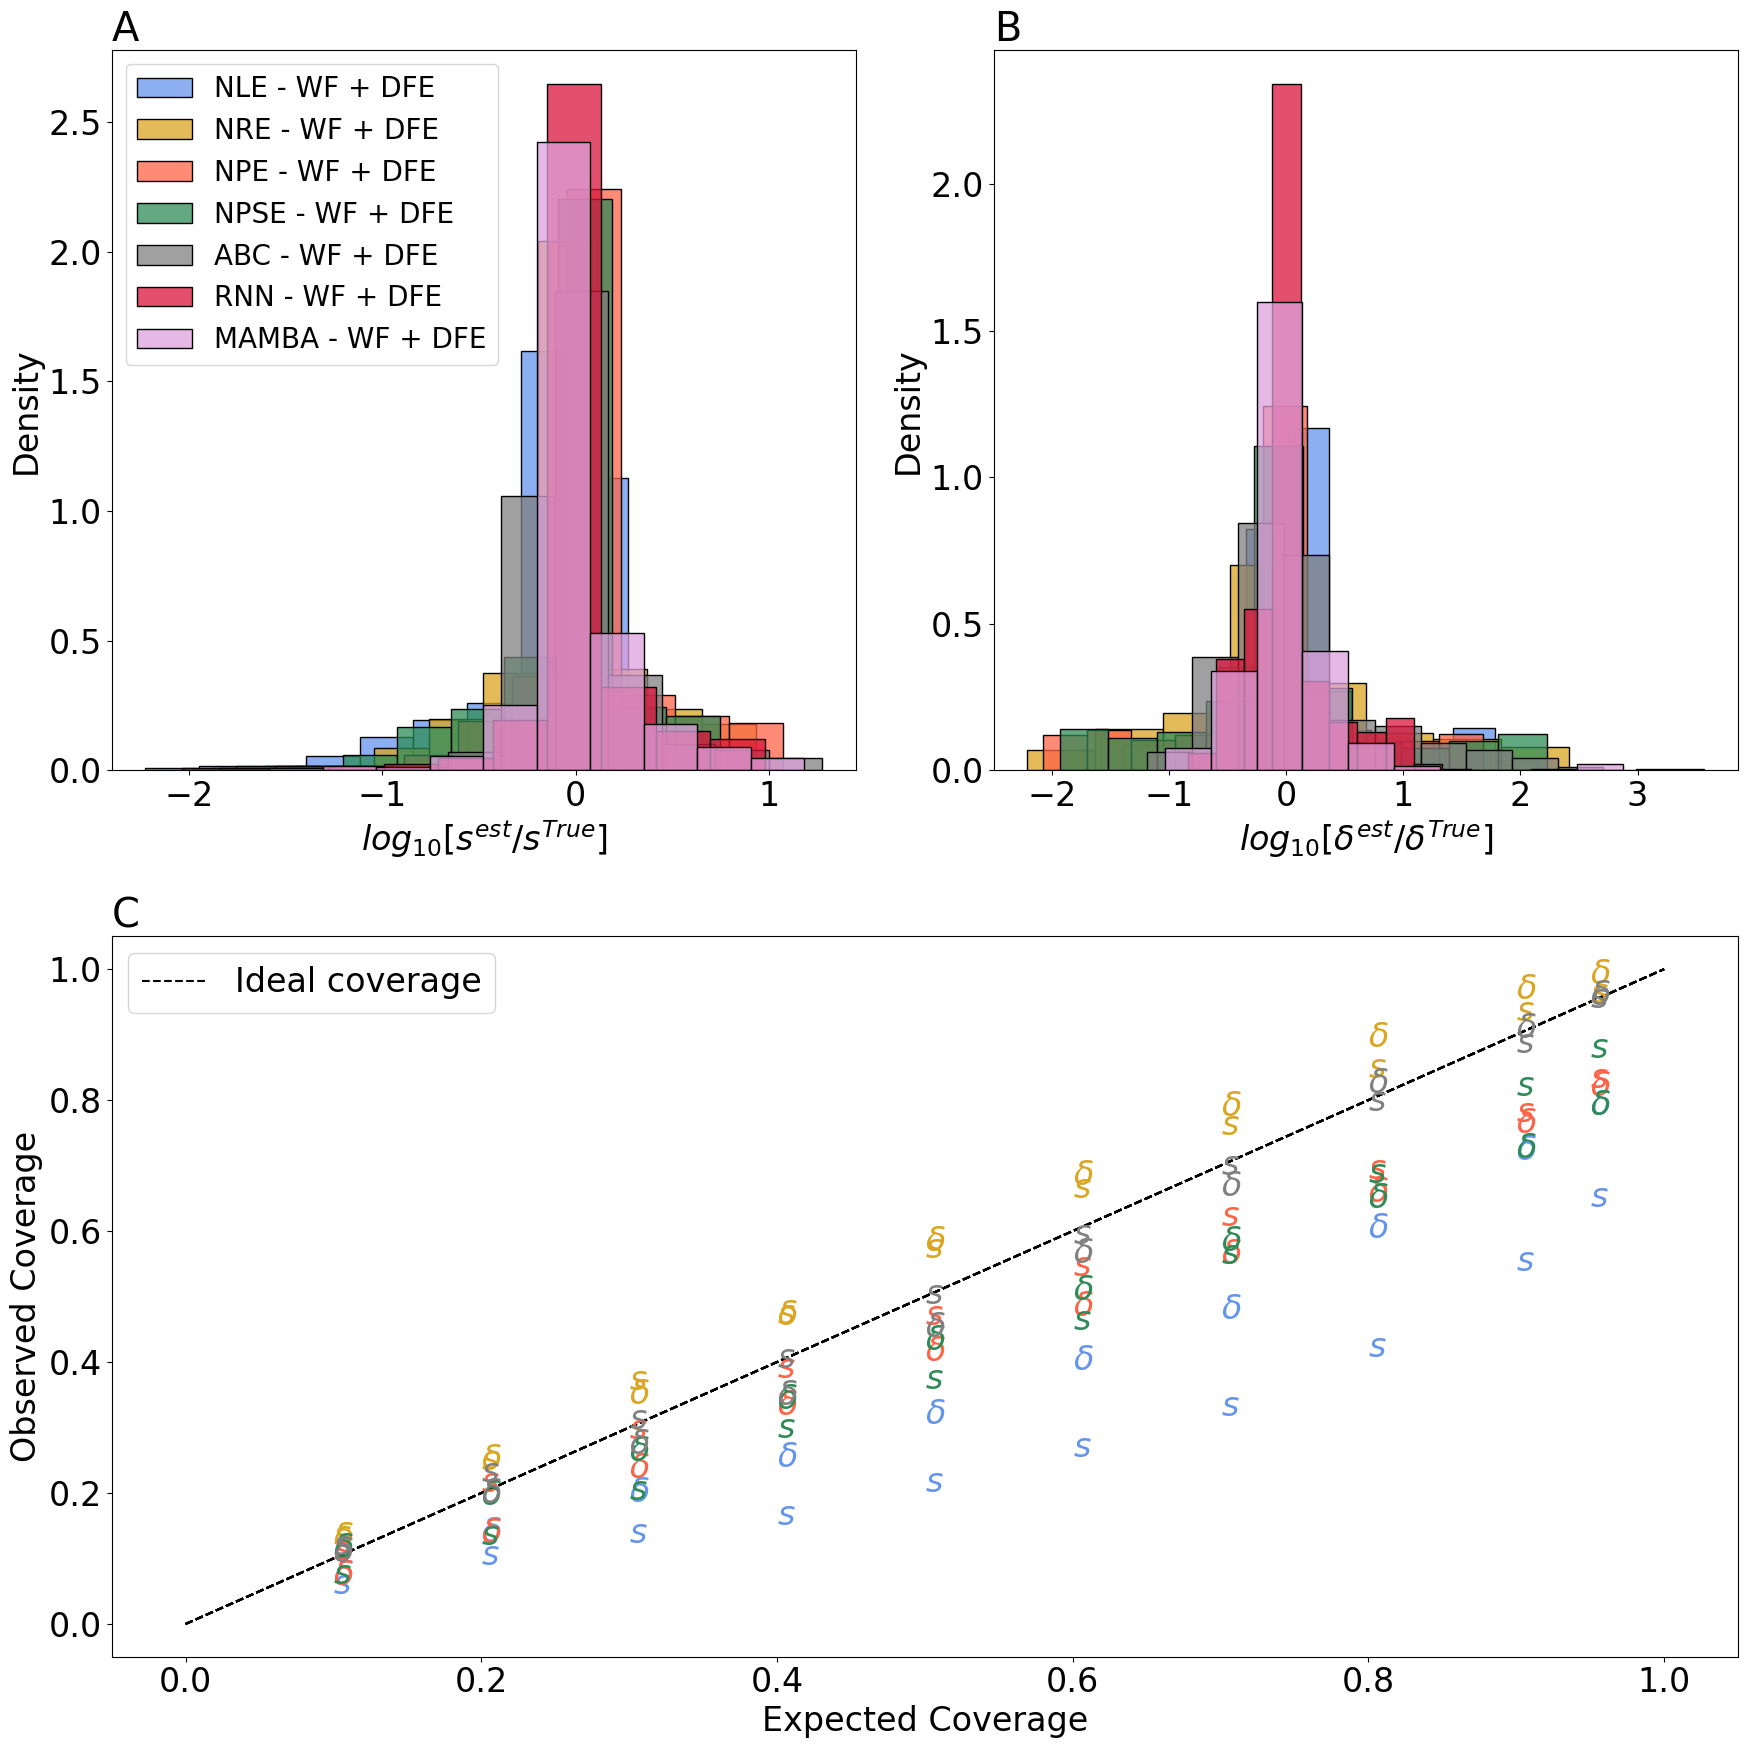

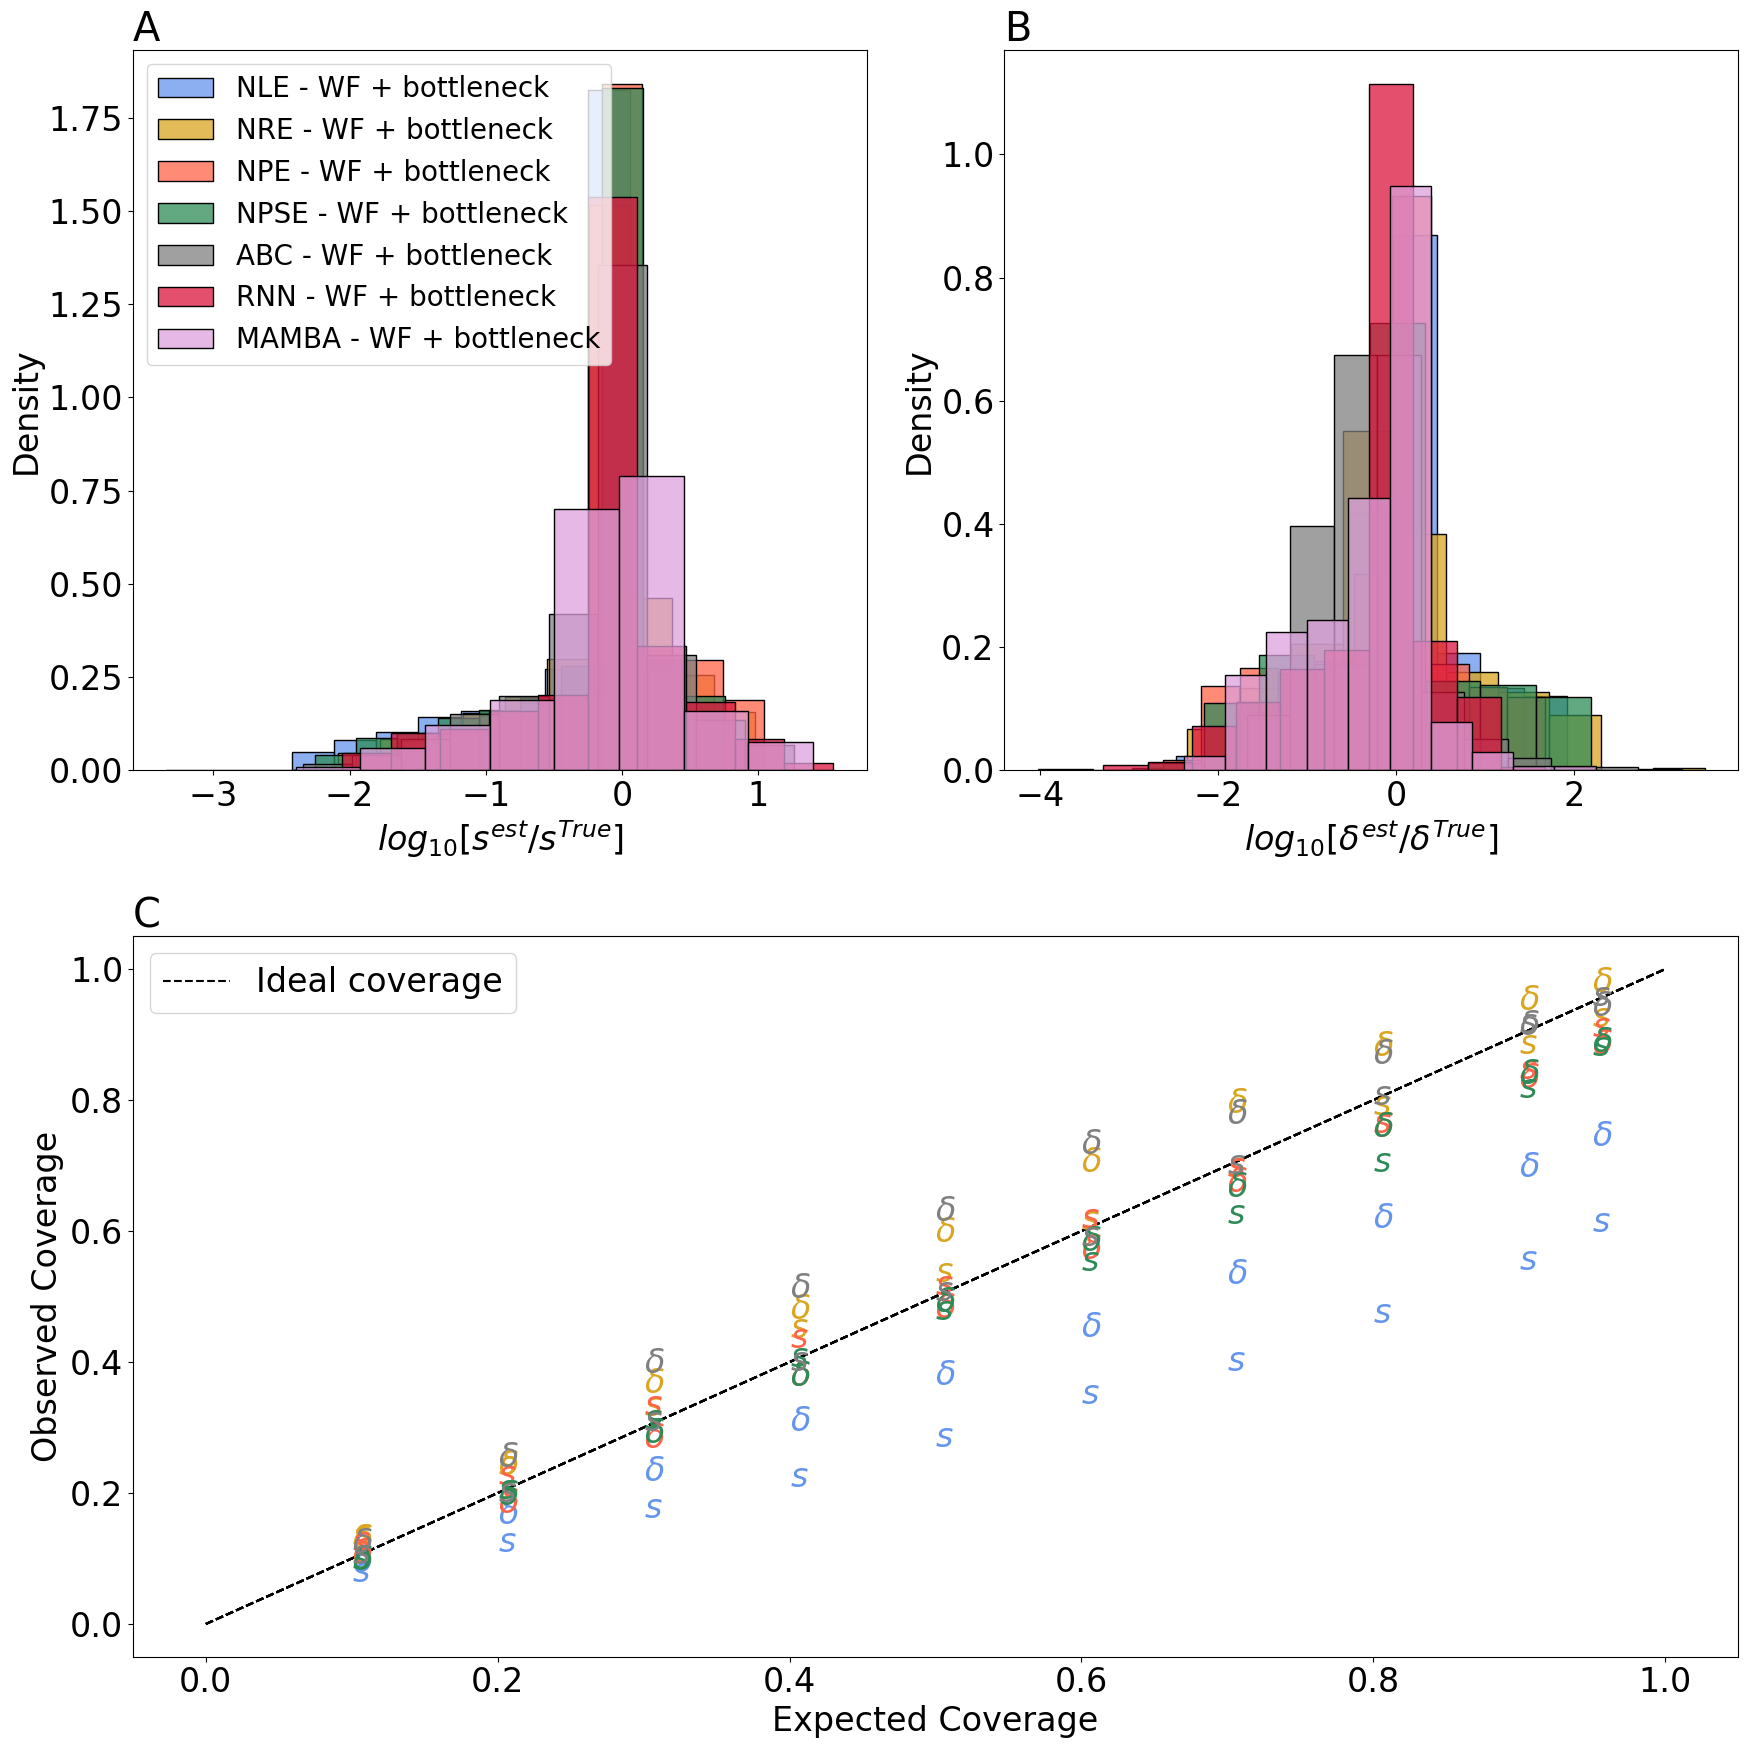

In [7]:
mosaic = '''AB
            CC
            '''
models = ['WF', 'WF_DFE', 'WF_bottleneck']

for model in models:
    fig, ax = plt.subplot_mosaic(mosaic,figsize=(18,18), tight_layout=True)
    neural_archs = ['nle', 'nre', 'npe', 'npse']
    colors = ['cornflowerblue', 'goldenrod', 'tomato', 'seagreen', 'grey', 'crimson', 'plum']
    for i in range(len(neural_archs)):
        plot_results(model, neural_archs[i], colors[i], fig, ax, cov_leg=False)
    plot_results(model, 'abc', 'grey', fig, ax, True, True)
    plot_results(model, 'rnn', 'crimson', fig, ax, False, False, True)
    plot_results(model, 'mamba', 'plum', fig, ax, False, False, True)


## Summarizing accuracies by thresholds in a single figure

In [8]:
def too_far(ests, thetas):
    threshes = [0.5,1]
    s_far = torch.abs(thetas-ests)[:,0] > threshes[0]
    delta_far = torch.abs(thetas-ests)[:,1] > threshes[1]
    fars_all = (s_far+delta_far).sum()/len(ests)
    fars_both = (s_far*delta_far).sum()/len(ests)
    return fars_both.item(), fars_all.item()


def rmse(x,y):
    return torch.sqrt(((y-x)**2).sum()/len(x))

def error(ests, xs):
    res = []
    for i in range(len(xs)):
        x = xs[i]
        s,m = 10**ests[i]
        pred = torch.from_numpy(WF(s,m,N=1e8, G=200))
        res.append(rmse(x,pred).item())
    return np.array(res).mean().item()

def est_in_numbers(model, arch):
    if arch in ['rnn', 'mamba']:
        ests = torch.load(f'test_sims/predictions_{model}_{arch}.pt').cpu()
    else:
        ests = torch.load(f'test_sims/samples_{model}_{arch}.pt').mean(0)
    thetas = torch.load(f'test_sims/test_theta_{model}.pt').cpu()
    xs = torch.load(f'test_sims/test_x_{model}.pt').cpu()
    too_far_0, too_far_1 = too_far(ests, thetas)
    rmse = round(error(ests, xs),4)
    return [too_far_0, too_far_1, rmse]



In [9]:
dfs=[]
for model in models:
    df = pd.DataFrame(index = neural_archs+['abc']+['rnn', 'mamba'], columns = ['large both', 'large either', 'rmse', 'model'])
    for arch in df.index:
        df.loc[arch,:] = est_in_numbers(model, arch)+[model]
    df.to_csv(f'test_sims/metrics_{model}.csv')
    dfs.append(df)
    print(df)

      large both large either    rmse model
nle        0.059        0.216  0.0052    WF
nre        0.115        0.354  0.0119    WF
npe        0.107        0.303  0.0038    WF
npse       0.092         0.32  0.0048    WF
abc        0.473        0.904  0.3185    WF
rnn        0.012         0.11  0.0165    WF
mamba        0.0        0.085   0.026    WF
      large both large either    rmse   model
nle        0.051        0.227  0.0142  WF_DFE
nre        0.091        0.336  0.0139  WF_DFE
npe        0.087        0.277  0.0123  WF_DFE
npse       0.076        0.322  0.0155  WF_DFE
abc        0.469        0.916  0.3179  WF_DFE
rnn        0.007        0.091  0.0254  WF_DFE
mamba      0.004        0.089  0.0377  WF_DFE
      large both large either    rmse          model
nle        0.097        0.346  0.0162  WF_bottleneck
nre        0.148        0.431  0.0129  WF_bottleneck
npe        0.114        0.429  0.0141  WF_bottleneck
npse        0.14        0.443  0.0133  WF_bottleneck
abc        0.48

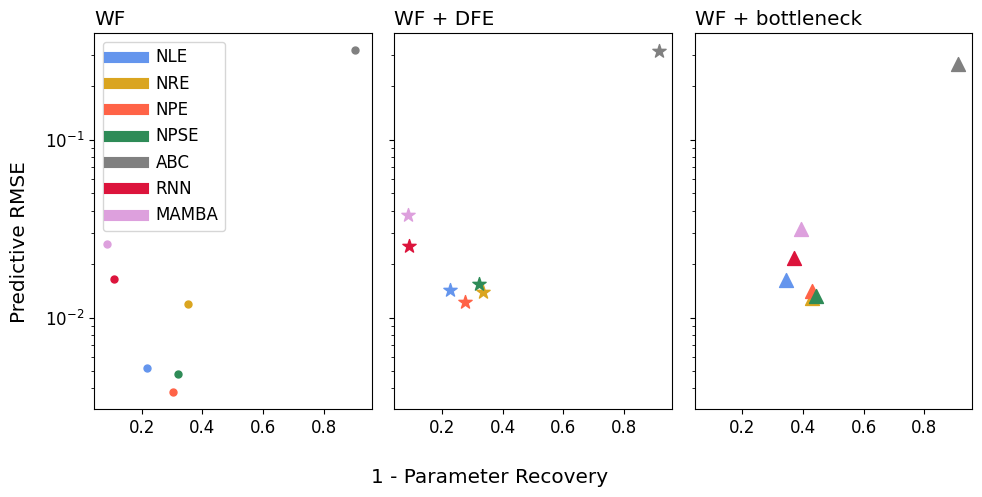

In [31]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1,3, sharex=True, sharey=True, figsize=(10,5), tight_layout=True)
change_font(12)
marker_dict = {'WF':'.', 'WF_DFE':'*', 'WF_bottleneck':'^'}

def plot_reovery_and_rmse(df, ax):
    df['Estimation error'] = df.iloc[:,1]

    for i in range(len(df.index)):
        arch = df.index[i]
        t = df.loc[arch]
        model = t['model']
        ax.scatter(x=t['Estimation error'], y=t['rmse'], color=colors[i], label=arch.upper() if model=='WF' else '', marker=marker_dict[model], s=100)
    ax.set_title(model.replace('_', ' + '), loc='left')

for i in range(3):
    plot_reovery_and_rmse(dfs[i], ax[i])

legend_elements = []
for i in range(len(df.index)):
    legend_elements.append(Line2D([0], [0], color=colors[i], lw=8, label=df.index[i].upper()))
# for m in marker_dict.keys():
#     legend_elements.append(Line2D([0], [0], color='k', marker=marker_dict[m], label=m.replace('_', ' + '), markersize=15, lw=0))
ax[0].legend(handles=legend_elements)
fig.supylabel('Predictive RMSE')
fig.supxlabel('1 - Parameter Recovery')
for i in range(3):
    ax[i].set_yscale('log')

## RMSE landscape - Exploring the weird correlation

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

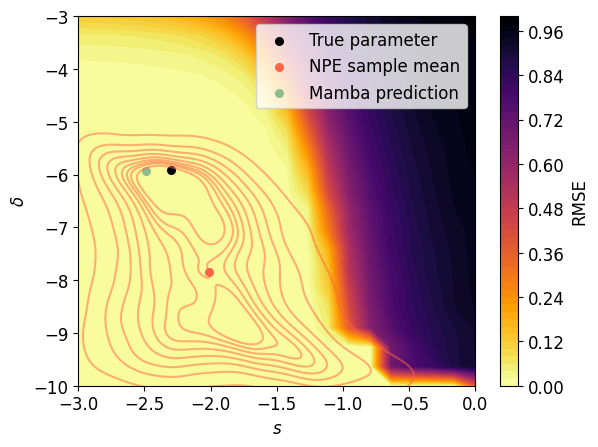

In [209]:
from inference_utils import get_prior
from seaborn import kdeplot
prior = get_prior()
change_font(12)


def rmse(x,y):
    return np.sqrt(((y-x)**2).sum()/len(x))

def rmse_landscape(x, n=100, simulator=WF, prior=prior, N=int(1e8), G=200):
    
    s_vals = np.linspace(prior.base_dist.low[0], prior.base_dist.high[0], n)
    m_vals = np.linspace(prior.base_dist.low[1], prior.base_dist.high[1], n)
    rmses = np.zeros((n,n))
    for i in range(len(s_vals)):
        s = 10**s_vals[i]
        for j in range(len(m_vals)):
            m = 10**m_vals[j]
            sim = simulator(s,m,N,G)
            rmse_ = rmse(x, sim)
            rmses[i,j] = rmse_
    return s_vals, m_vals, rmses.T

t = 527
thetas = torch.load('test_sims/test_theta_WF.pt')
theta = thetas[t]

mamba_predictions = torch.load('test_sims/mamba_predictions_WF.pt')
mamba_s, mamba_m = mamba_predictions[t,0], mamba_predictions[t,1]

s=10**theta[0]
m=10**theta[1]
N=int(1e8)
G=200
x = WF(s,m,N,G)
s_vals, m_vals, rmses = rmse_landscape(x, n=20, prior=prior, simulator=WF, N=N, G=G)

fig, ax = plt.subplots()
ax.set_xlim(-3,0)
ax.set_ylim(-10,-3)

lev_exp = np.linspace(np.floor(np.log10(rmses.min())),
                   np.ceil(np.log10(rmses.max())), 50)
levs = np.power(10, lev_exp)
# ax.set_xlim(-0.8,-0.4)
# ax.set_ylim(-9,-7)
c = ax.contourf(s_vals, m_vals, rmses, levels=50, cmap='inferno_r')
plt.colorbar(c, label='RMSE')
ax.set_xlabel('$s$')
ax.set_ylabel('$δ$')
posterior = pickle.load(open('posteriors/posterior_npe.pkl','rb'))
samples = posterior.set_default_x(x).sample((10_000,))
s_s, m_s = samples[:,0].numpy(), samples[:,1].numpy()
k = kdeplot(ax=ax, x=s_s,y=m_s, color='tomato', alpha=0.5, levels=10)

ax.scatter(theta[0],theta[1], color='k', label='True parameter', s=30)
ax.scatter(s_s.mean(),m_s.mean(), color='tomato', label='NPE sample mean', s=30)
ax.scatter(mamba_s.cpu(), mamba_m.cpu(), color='darkseagreen', label='Mamba prediction', s=30)

ax.legend()

# Two mutation model

## Misspecification - A misleading case study

Text(0.5, 0, '$log_{10}[s^{est} / {s^{True}}]$')

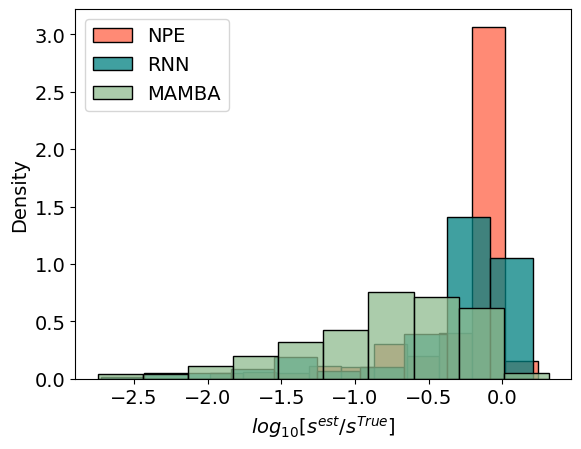

In [35]:
change_font(14)

npes = torch.load('test_sims/samples_combined_mis_npe.pt').mean(0)
rnns = torch.load('test_sims/predictions_combined_mis_rnn.pt')
mambas = torch.load('test_sims/predictions_combined_mis_mamba.pt').cpu()
thetas = torch.load('test_sims/test_theta_combined_mis.pt')

histplot(samples[ind,0] - thetas[ind,4], stat='density', color='tomato', bins=10, label='NPE')
histplot(predictions[ind,0] - thetas[ind,4], stat='density', color='teal', bins=10, label='RNN')
histplot(mambas[ind,0] - thetas[ind,4], stat='density', color='darkseagreen', bins=10, label='MAMBA')
plt.legend()
plt.xlabel('$log_{10}[s^{est} / {s^{True}}]$')

## Accuracy on Two-mutation model (NPE vs. Mamba)

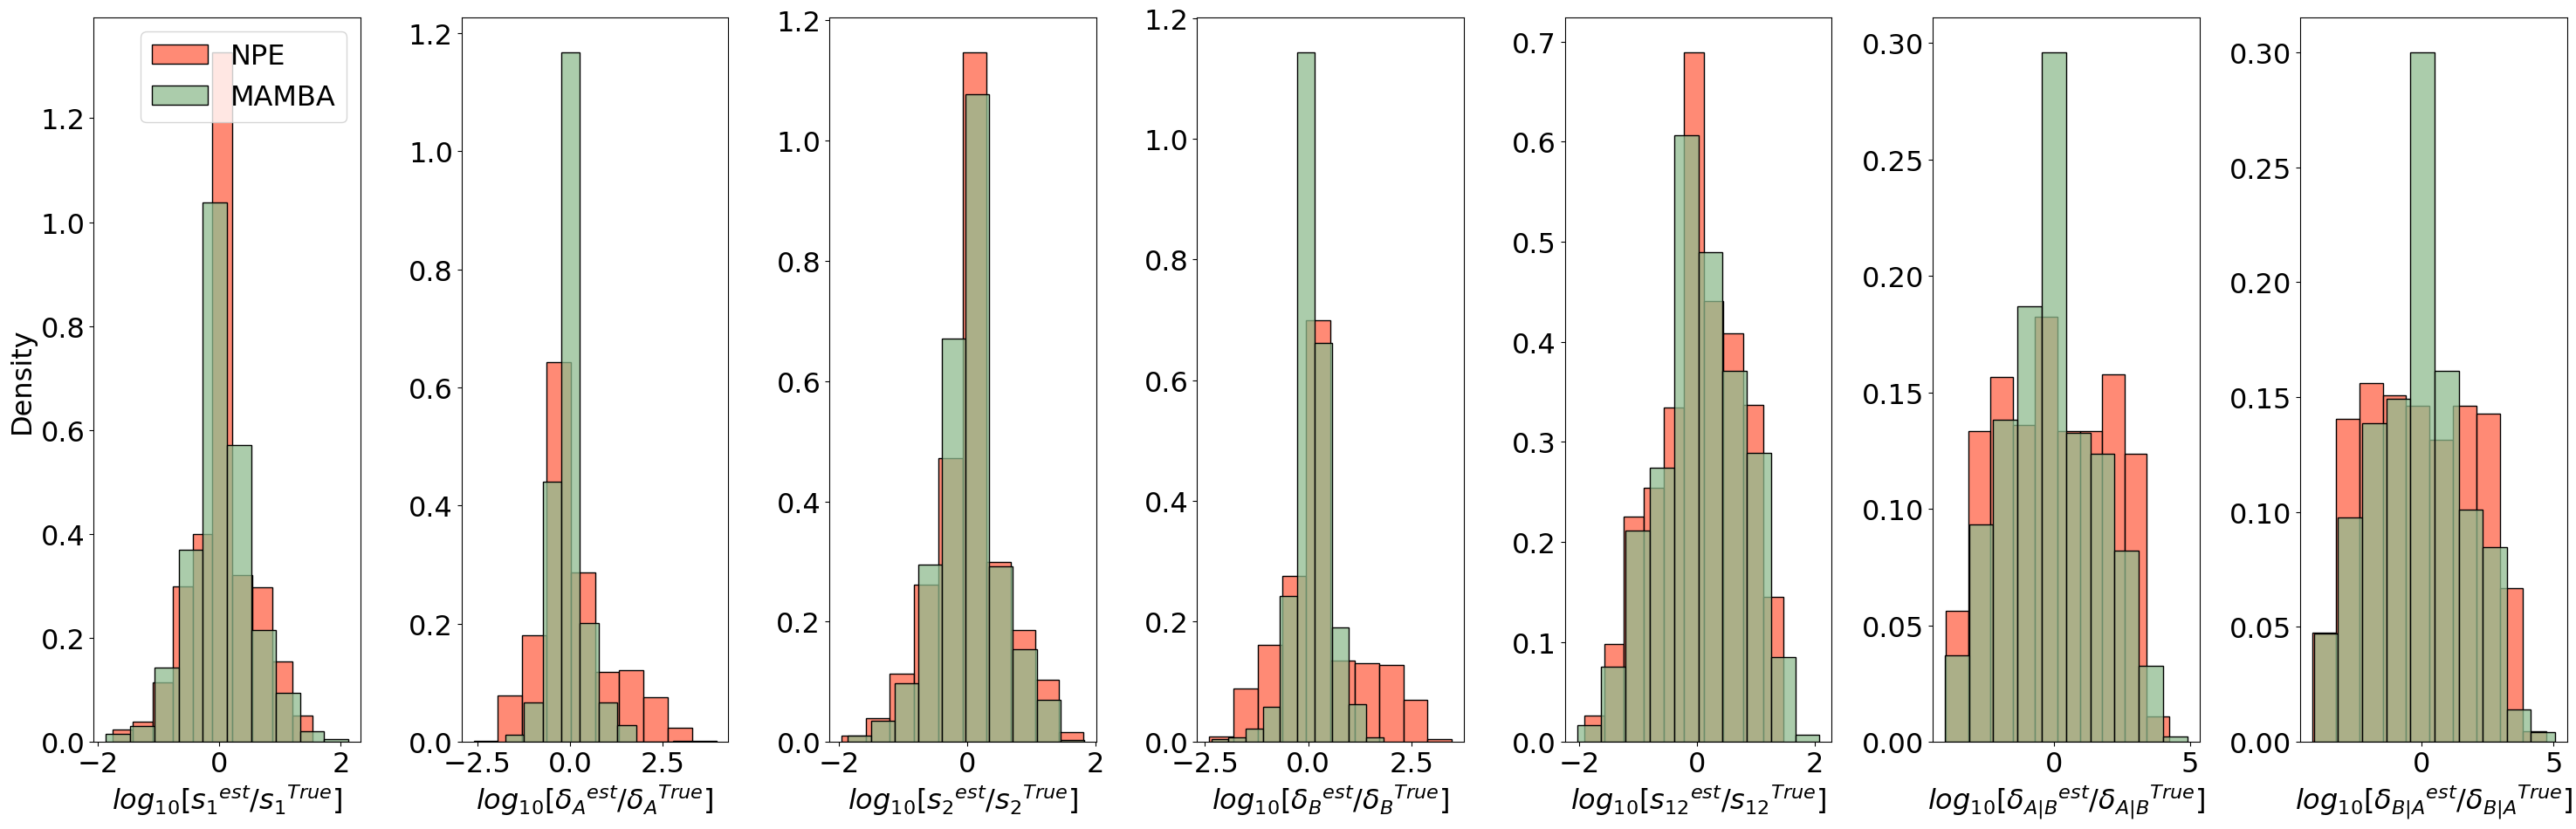

In [9]:
def accuracy(samples, thetas, abc=False, non_sbi=False):
    if non_sbi:
        return samples - thetas
    accs = torch.empty(len(thetas),len(thetas[0]))
    for i in range(len(thetas)):
        samps = samples[:,i]
        if abc:
            samps = samples[i]
        accs[i] = samps.mean(0) - thetas[i]
    return accs

def plot_accuracy(ax, accs, color, label):
    for i in range(len(ax)):
        histplot(accs[:,i],ax=ax[i], stat='density', color=color, bins=10, label=label if i==0 else '')
        # kdeplot(accs[:,i],ax=ax[i],fill=True, color=color, label=label)
    return

change_font(23)

fig, ax = plt.subplots(1,7, tight_layout=True, figsize=(30,10))
samples = torch.load('test_sims/samples_combined_npe_combined.pt')
preds = torch.load('test_sims/predictions_combined_mamba_combined.pt').cpu()
thetas = torch.load('test_sims/test_theta_combined.pt')
accs_npe = accuracy(samples, thetas)
accs_mamba = accuracy(preds, thetas, non_sbi=True)
plot_accuracy(ax,accs_npe,'tomato', 'NPE')
plot_accuracy(ax,accs_mamba,'darkseagreen','MAMBA')
ax[0].legend()

for i in range(6):
    ax[i+1].set_ylabel('')

ax[0].set_xlabel('$log_{10}[{s_1}^{est} / {{s_1}^{True}}]$')
ax[2].set_xlabel('$log_{10}[{s_2}^{est} / {{s_2}^{True}}]$')
ax[4].set_xlabel('$log_{10}[{s_{12}}^{est} / {{s_{12}}^{True}}]$')

ax[1].set_xlabel('$log_{10}[{\delta_A}^{est} / {{\delta_A}^{True}}]$')
ax[3].set_xlabel('$log_{10}[{\delta_B}^{est} / {{\delta_B}^{True}}]$')
ax[5].set_xlabel('$log_{10}[{\delta_{A|B}}^{est} / {{\delta_{A|B}}^{True}}]$')
ax[6].set_xlabel('$log_{10}[{\delta_{B|A}}^{est} / {{\delta_{B|A}}^{True}}]$')
print()